In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa, librosa.display
import os
import tensorflow as tf
print(tf.__version__)
import re
import sklearn
import datetime
import pandas as apd
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
%load_ext tensorboard
tf.random.set_seed(999)
np.random.seed(999)
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, LeakyReLU, Flatten, Dense, Reshape, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Dropout, SpatialDropout2D
from tensorflow.keras import Model, Sequential

2.0.0


In [2]:
## librosa config
NUM_CLASSES=5
SAMPLE_RATE=16000
N_MFCC=40
WINDOW_LENGTH=512
OVERLAP=round(0.25 * WINDOW_LENGTH)
BATCH_SIZE=8
LEARNING_RATE=8e-5

In [3]:
# save the numpy data
X_train = np.load('../data/processed/TDC_VoIP_train512.npy', allow_pickle=True).item()
X_test = np.load('../data/processed/TDC_VoIP_test512.npy', allow_pickle=True).item()

In [4]:
train_filenames = X_train['filenames']
y_train_scores = X_train['sample_MOS']
y_train_classes = X_train['class_labels']
X_train_features = X_train['features']
input_height = X_train_features.shape[1]

print("Train data")
print("Features shape:", X_train_features.shape)
print("class_labels shape:", y_train_classes.shape)
print("sample_MOS shape:", y_train_scores.shape)

Train data
Features shape: (327, 257, 1241, 1)
class_labels shape: (327,)
sample_MOS shape: (327,)


In [5]:
test_filenames = X_test['filenames']
y_test_scores = X_test['sample_MOS']
y_test_classes = X_test['class_labels']
X_test_features = X_test['features']

print("Test data")
print("Features shape:", X_test_features.shape)
print("class_labels shape:", y_test_classes.shape)
print("sample_MOS shape:", y_test_scores.shape)

Test data
Features shape: (57, 257, 1241, 1)
class_labels shape: (57,)
sample_MOS shape: (57,)


In [6]:

## normalization
def whitening(feature_vector):
    # print(feature_vector.shape)
    mean = np.expand_dims(np.mean(feature_vector))
    std = np.expand_dims(np.std(feature_vector))
    feature_vector = (feature_vector - mean) / std
    return feature_vector

## ConvNet architecture

In [7]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs

    # Conv --> BN --> Activation --> MaxPool --> [Dropout 2D]
    x = Conv2D(filters=16, kernel_size=3, padding='same', input_shape=input_shape)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=24, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=24, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.15)(x)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.25)(x)
    
    # scores branch 
    x_score = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x_score = BatchNormalization()(x_score)
    x_score = Activation('relu')(x_score)
    x_score = MaxPooling2D(pool_size=2)(x_score)
    x_score = SpatialDropout2D(0.25)(x_score)

    x_score = Conv2D(filters=32, kernel_size=3, padding='same')(x_score)
    x_score = BatchNormalization()(x_score)
    x_score = Activation('relu')(x_score)
    x_score = MaxPooling2D(pool_size=2)(x_score)
    x_score = SpatialDropout2D(0.25)(x_score)
    x_score = GlobalAveragePooling2D()(x_score)
    x_score = Dense(1, name='output_mos')(x_score)

    # claas branch 
    x_class = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x_class = BatchNormalization()(x_class)
    x_class = Activation('relu')(x_class)
    x_class = MaxPooling2D(pool_size=2)(x_class)
    x_class = SpatialDropout2D(0.25)(x_class)

    x_class = Conv2D(filters=48, kernel_size=3, padding='same')(x_class)
    x_class = BatchNormalization()(x_class)
    x_class = Activation('relu')(x_class)
    x_class = MaxPooling2D(pool_size=2)(x_class)
    x_class = SpatialDropout2D(0.35)(x_class)
    x_class = GlobalAveragePooling2D()(x_class)
    x_class = Dense(NUM_CLASSES, activation='softmax', name='output_class')(x_class)
    
    model = Model(inputs=inputs, outputs=[x_score, x_class])
    return model

In [8]:
model = build_model((input_height, None, 1))

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(loss={'output_mos': 'mse', 
                    'output_class': 'sparse_categorical_crossentropy'}, 
              loss_weights={'output_mos': 1, 
                    'output_class': 0.035137951618966407},
              metrics={'output_mos': tf.keras.metrics.RootMeanSquaredError(), 
                    'output_class': tf.keras.metrics.SparseCategoricalAccuracy()},
              optimizer=optimizer)

# Display model architecture summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 257, None, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 257, None, 16 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 257, None, 16 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 257, None, 16 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
monitor_metric='val_loss'

early_stopping_callback = tf.keras.callbacks.EarlyStopping(mode='auto', monitor=monitor_metric, patience=100, restore_best_weights=True)

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='epoch')
#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='drive/My Drive/audio-quality-cnn/model.h5', 
#                                                          monitor=monitor_metric, save_best_only=True)

In [10]:
def whitening(image, y1, y2):
    # normalization using the image mean and std tends to produce under-optimized models
    # mean = tf.math.reduce_mean(image)
    # std = tf.math.reduce_std(image)
    mean = tf.expand_dims(tf.math.reduce_mean(image, axis=1), axis=1)
    std = tf.expand_dims(tf.math.reduce_std(image, axis=1), axis=1)
    image = (image - mean) / std
    return image, y1, y2
    
def random_crop(image, y1, y2):
    h = image.shape[0]
    return tf.math.abs(tf.image.random_crop(image, size=(h,416,1))), y1, y2

def cutout(image, y1, y2, cutout_size=24):
    h, w = image.shape[:2]
    mask = tf.zeros((24,24))

    left = tf.random.uniform(shape=(), minval=0, maxval=w-cutout_size, dtype=tf.int32)
    right = w - (cutout_size + left)

    top = tf.random.uniform(shape=(), minval=0, maxval=h-cutout_size, dtype=tf.int32)
    bottom = h - (cutout_size + top)

    mask = tf.pad(mask, [[top, bottom], [left, right]], constant_values=1)
    image = image * tf.expand_dims(mask, 2)
    return image, label

def prepare_input_format(image, y1, y2):
    return image, {'output_mos': y1, 'output_class': y2}

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_features, y_train_scores, y_train_classes))
train_dataset = train_dataset.map(random_crop)
train_dataset = train_dataset.map(whitening)
train_dataset = train_dataset.map(prepare_input_format)
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)

In [40]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_features, y_test_scores, y_test_classes))
test_dataset = test_dataset.map(whitening)
test_dataset = test_dataset.map(prepare_input_format)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(256)

In [13]:
steps_per_epoch = X_train_features.shape[0] // BATCH_SIZE
print("steps_per_epoch:",steps_per_epoch)

steps_per_epoch: 40


In [14]:
history = model.fit(X_train_features,
          {'output_mos': y_train_scores, 'output_class': y_train_classes},
          validation_data=(X_test_features, 
                           {'output_mos': y_test_scores, 'output_class': y_test_classes}),
          batch_size=BATCH_SIZE,
          epochs=1000,
          callbacks=[early_stopping_callback]
        )

Train on 327 samples, validate on 57 samples
Epoch 1/1000
327/327 [==============================] - 147s 450ms/sample - loss: 0.6493 - output_mos_loss: 0.5803 - output_class_loss: 1.9510 - output_mos_root_mean_squared_error: 0.7621 - output_class_sparse_categorical_accuracy: 0.1774 - val_loss: 0.4665 - val_output_mos_loss: 0.3999 - val_output_class_loss: 1.5798 - val_output_mos_root_mean_squared_error: 0.6407 - val_output_class_sparse_categorical_accuracy: 0.2456
Epoch 2/1000
327/327 [==============================] - 131s 400ms/sample - loss: 0.5640 - output_mos_loss: 0.4987 - output_class_loss: 1.8324 - output_mos_root_mean_squared_error: 0.7068 - output_class_sparse_categorical_accuracy: 0.2080 - val_loss: 0.5324 - val_output_mos_loss: 0.4687 - val_output_class_loss: 1.5521 - val_output_mos_root_mean_squared_error: 0.6907 - val_output_class_sparse_categorical_accuracy: 0.2982
Epoch 3/1000
327/327 [==============================] - 134s 409ms/sample - loss: 0.4566 - output_mos_loss:

327/327 [==============================] - 143s 436ms/sample - loss: 0.2025 - output_mos_loss: 0.1458 - output_class_loss: 1.6162 - output_mos_root_mean_squared_error: 0.3817 - output_class_sparse_categorical_accuracy: 0.3089 - val_loss: 0.1119 - val_output_mos_loss: 0.0541 - val_output_class_loss: 1.3989 - val_output_mos_root_mean_squared_error: 0.2466 - val_output_class_sparse_categorical_accuracy: 0.4035
Epoch 40/1000
327/327 [==============================] - 151s 460ms/sample - loss: 0.2325 - output_mos_loss: 0.1767 - output_class_loss: 1.5949 - output_mos_root_mean_squared_error: 0.4200 - output_class_sparse_categorical_accuracy: 0.2966 - val_loss: 0.1125 - val_output_mos_loss: 0.0548 - val_output_class_loss: 1.3919 - val_output_mos_root_mean_squared_error: 0.2480 - val_output_class_sparse_categorical_accuracy: 0.3860
Epoch 41/1000
327/327 [==============================] - 149s 456ms/sample - loss: 0.2076 - output_mos_loss: 0.1522 - output_class_loss: 1.5722 - output_mos_root_me

327/327 [==============================] - 128s 392ms/sample - loss: 0.1799 - output_mos_loss: 0.1254 - output_class_loss: 1.5497 - output_mos_root_mean_squared_error: 0.3541 - output_class_sparse_categorical_accuracy: 0.3150 - val_loss: 0.1006 - val_output_mos_loss: 0.0457 - val_output_class_loss: 1.3496 - val_output_mos_root_mean_squared_error: 0.2258 - val_output_class_sparse_categorical_accuracy: 0.4211
Epoch 78/1000
327/327 [==============================] - 128s 393ms/sample - loss: 0.1574 - output_mos_loss: 0.1032 - output_class_loss: 1.5386 - output_mos_root_mean_squared_error: 0.3214 - output_class_sparse_categorical_accuracy: 0.3486 - val_loss: 0.1003 - val_output_mos_loss: 0.0456 - val_output_class_loss: 1.3505 - val_output_mos_root_mean_squared_error: 0.2252 - val_output_class_sparse_categorical_accuracy: 0.4211
Epoch 79/1000
327/327 [==============================] - 131s 399ms/sample - loss: 0.1597 - output_mos_loss: 0.1042 - output_class_loss: 1.5745 - output_mos_root_me

327/327 [==============================] - 131s 399ms/sample - loss: 0.1337 - output_mos_loss: 0.0792 - output_class_loss: 1.5530 - output_mos_root_mean_squared_error: 0.2812 - output_class_sparse_categorical_accuracy: 0.3028 - val_loss: 0.0877 - val_output_mos_loss: 0.0352 - val_output_class_loss: 1.3283 - val_output_mos_root_mean_squared_error: 0.1959 - val_output_class_sparse_categorical_accuracy: 0.3509
Epoch 116/1000
327/327 [==============================] - 129s 393ms/sample - loss: 0.1446 - output_mos_loss: 0.0893 - output_class_loss: 1.5772 - output_mos_root_mean_squared_error: 0.2987 - output_class_sparse_categorical_accuracy: 0.3364 - val_loss: 0.0884 - val_output_mos_loss: 0.0360 - val_output_class_loss: 1.3238 - val_output_mos_root_mean_squared_error: 0.1984 - val_output_class_sparse_categorical_accuracy: 0.3684
Epoch 117/1000
327/327 [==============================] - 128s 393ms/sample - loss: 0.1335 - output_mos_loss: 0.0791 - output_class_loss: 1.5490 - output_mos_root_

327/327 [==============================] - 128s 393ms/sample - loss: 0.1128 - output_mos_loss: 0.0607 - output_class_loss: 1.4928 - output_mos_root_mean_squared_error: 0.2456 - output_class_sparse_categorical_accuracy: 0.3700 - val_loss: 0.0854 - val_output_mos_loss: 0.0336 - val_output_class_loss: 1.2919 - val_output_mos_root_mean_squared_error: 0.1929 - val_output_class_sparse_categorical_accuracy: 0.3684
Epoch 154/1000
327/327 [==============================] - 129s 394ms/sample - loss: 0.1200 - output_mos_loss: 0.0677 - output_class_loss: 1.4935 - output_mos_root_mean_squared_error: 0.2599 - output_class_sparse_categorical_accuracy: 0.3456 - val_loss: 0.0844 - val_output_mos_loss: 0.0327 - val_output_class_loss: 1.2921 - val_output_mos_root_mean_squared_error: 0.1898 - val_output_class_sparse_categorical_accuracy: 0.3509
Epoch 155/1000
327/327 [==============================] - 129s 393ms/sample - loss: 0.1128 - output_mos_loss: 0.0604 - output_class_loss: 1.4923 - output_mos_root_

327/327 [==============================] - 132s 403ms/sample - loss: 0.1090 - output_mos_loss: 0.0568 - output_class_loss: 1.4869 - output_mos_root_mean_squared_error: 0.2383 - output_class_sparse_categorical_accuracy: 0.3761 - val_loss: 0.0779 - val_output_mos_loss: 0.0295 - val_output_class_loss: 1.2330 - val_output_mos_root_mean_squared_error: 0.1777 - val_output_class_sparse_categorical_accuracy: 0.4211
Epoch 192/1000
327/327 [==============================] - 131s 401ms/sample - loss: 0.1020 - output_mos_loss: 0.0513 - output_class_loss: 1.4403 - output_mos_root_mean_squared_error: 0.2266 - output_class_sparse_categorical_accuracy: 0.3945 - val_loss: 0.0772 - val_output_mos_loss: 0.0288 - val_output_class_loss: 1.2324 - val_output_mos_root_mean_squared_error: 0.1756 - val_output_class_sparse_categorical_accuracy: 0.3860
Epoch 193/1000
327/327 [==============================] - 130s 397ms/sample - loss: 0.1052 - output_mos_loss: 0.0530 - output_class_loss: 1.4868 - output_mos_root_

327/327 [==============================] - 129s 393ms/sample - loss: 0.1012 - output_mos_loss: 0.0520 - output_class_loss: 1.3983 - output_mos_root_mean_squared_error: 0.2282 - output_class_sparse_categorical_accuracy: 0.4220 - val_loss: 0.0768 - val_output_mos_loss: 0.0280 - val_output_class_loss: 1.2034 - val_output_mos_root_mean_squared_error: 0.1765 - val_output_class_sparse_categorical_accuracy: 0.3509
Epoch 230/1000
327/327 [==============================] - 128s 392ms/sample - loss: 0.1052 - output_mos_loss: 0.0539 - output_class_loss: 1.4586 - output_mos_root_mean_squared_error: 0.2322 - output_class_sparse_categorical_accuracy: 0.3823 - val_loss: 0.0744 - val_output_mos_loss: 0.0268 - val_output_class_loss: 1.1857 - val_output_mos_root_mean_squared_error: 0.1719 - val_output_class_sparse_categorical_accuracy: 0.4561
Epoch 231/1000
327/327 [==============================] - 130s 397ms/sample - loss: 0.0994 - output_mos_loss: 0.0495 - output_class_loss: 1.4213 - output_mos_root_

327/327 [==============================] - 130s 398ms/sample - loss: 0.1016 - output_mos_loss: 0.0525 - output_class_loss: 1.3994 - output_mos_root_mean_squared_error: 0.2290 - output_class_sparse_categorical_accuracy: 0.3914 - val_loss: 0.0741 - val_output_mos_loss: 0.0268 - val_output_class_loss: 1.1599 - val_output_mos_root_mean_squared_error: 0.1730 - val_output_class_sparse_categorical_accuracy: 0.4561
Epoch 268/1000
327/327 [==============================] - 131s 401ms/sample - loss: 0.0984 - output_mos_loss: 0.0478 - output_class_loss: 1.4380 - output_mos_root_mean_squared_error: 0.2188 - output_class_sparse_categorical_accuracy: 0.3609 - val_loss: 0.0747 - val_output_mos_loss: 0.0276 - val_output_class_loss: 1.1556 - val_output_mos_root_mean_squared_error: 0.1757 - val_output_class_sparse_categorical_accuracy: 0.4912
Epoch 269/1000
327/327 [==============================] - 130s 398ms/sample - loss: 0.1003 - output_mos_loss: 0.0508 - output_class_loss: 1.4099 - output_mos_root_

327/327 [==============================] - 130s 396ms/sample - loss: 0.0876 - output_mos_loss: 0.0388 - output_class_loss: 1.3881 - output_mos_root_mean_squared_error: 0.1970 - output_class_sparse_categorical_accuracy: 0.4312 - val_loss: 0.0743 - val_output_mos_loss: 0.0277 - val_output_class_loss: 1.1302 - val_output_mos_root_mean_squared_error: 0.1765 - val_output_class_sparse_categorical_accuracy: 0.4737
Epoch 306/1000
327/327 [==============================] - 128s 392ms/sample - loss: 0.0950 - output_mos_loss: 0.0461 - output_class_loss: 1.3895 - output_mos_root_mean_squared_error: 0.2148 - output_class_sparse_categorical_accuracy: 0.4220 - val_loss: 0.0764 - val_output_mos_loss: 0.0294 - val_output_class_loss: 1.1367 - val_output_mos_root_mean_squared_error: 0.1817 - val_output_class_sparse_categorical_accuracy: 0.4386
Epoch 307/1000
327/327 [==============================] - 129s 393ms/sample - loss: 0.0937 - output_mos_loss: 0.0438 - output_class_loss: 1.4247 - output_mos_root_

327/327 [==============================] - 109s 335ms/sample - loss: 0.0906 - output_mos_loss: 0.0431 - output_class_loss: 1.3525 - output_mos_root_mean_squared_error: 0.2076 - output_class_sparse_categorical_accuracy: 0.4465 - val_loss: 0.0686 - val_output_mos_loss: 0.0236 - val_output_class_loss: 1.0985 - val_output_mos_root_mean_squared_error: 0.1625 - val_output_class_sparse_categorical_accuracy: 0.4912
Epoch 344/1000
327/327 [==============================] - 109s 334ms/sample - loss: 0.0887 - output_mos_loss: 0.0408 - output_class_loss: 1.3643 - output_mos_root_mean_squared_error: 0.2018 - output_class_sparse_categorical_accuracy: 0.4251 - val_loss: 0.0684 - val_output_mos_loss: 0.0235 - val_output_class_loss: 1.0977 - val_output_mos_root_mean_squared_error: 0.1625 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 345/1000
327/327 [==============================] - 123s 376ms/sample - loss: 0.0941 - output_mos_loss: 0.0444 - output_class_loss: 1.4189 - output_mos_root_

327/327 [==============================] - 114s 349ms/sample - loss: 0.0894 - output_mos_loss: 0.0414 - output_class_loss: 1.3643 - output_mos_root_mean_squared_error: 0.2036 - output_class_sparse_categorical_accuracy: 0.4404 - val_loss: 0.0745 - val_output_mos_loss: 0.0287 - val_output_class_loss: 1.0984 - val_output_mos_root_mean_squared_error: 0.1794 - val_output_class_sparse_categorical_accuracy: 0.4912
Epoch 382/1000
327/327 [==============================] - 114s 350ms/sample - loss: 0.0913 - output_mos_loss: 0.0436 - output_class_loss: 1.3571 - output_mos_root_mean_squared_error: 0.2088 - output_class_sparse_categorical_accuracy: 0.4495 - val_loss: 0.0701 - val_output_mos_loss: 0.0252 - val_output_class_loss: 1.0866 - val_output_mos_root_mean_squared_error: 0.1683 - val_output_class_sparse_categorical_accuracy: 0.5263
Epoch 383/1000
327/327 [==============================] - 114s 349ms/sample - loss: 0.0878 - output_mos_loss: 0.0398 - output_class_loss: 1.3637 - output_mos_root_

327/327 [==============================] - 115s 353ms/sample - loss: 0.0826 - output_mos_loss: 0.0352 - output_class_loss: 1.3491 - output_mos_root_mean_squared_error: 0.1876 - output_class_sparse_categorical_accuracy: 0.4618 - val_loss: 0.0710 - val_output_mos_loss: 0.0263 - val_output_class_loss: 1.0695 - val_output_mos_root_mean_squared_error: 0.1716 - val_output_class_sparse_categorical_accuracy: 0.5263
Epoch 420/1000
327/327 [==============================] - 117s 358ms/sample - loss: 0.0847 - output_mos_loss: 0.0378 - output_class_loss: 1.3358 - output_mos_root_mean_squared_error: 0.1944 - output_class_sparse_categorical_accuracy: 0.4557 - val_loss: 0.0717 - val_output_mos_loss: 0.0268 - val_output_class_loss: 1.0745 - val_output_mos_root_mean_squared_error: 0.1731 - val_output_class_sparse_categorical_accuracy: 0.5263
Epoch 421/1000
327/327 [==============================] - 119s 365ms/sample - loss: 0.0836 - output_mos_loss: 0.0370 - output_class_loss: 1.3254 - output_mos_root_

327/327 [==============================] - 112s 342ms/sample - loss: 0.0829 - output_mos_loss: 0.0387 - output_class_loss: 1.2563 - output_mos_root_mean_squared_error: 0.1967 - output_class_sparse_categorical_accuracy: 0.4618 - val_loss: 0.0688 - val_output_mos_loss: 0.0249 - val_output_class_loss: 1.0479 - val_output_mos_root_mean_squared_error: 0.1671 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 458/1000
327/327 [==============================] - 112s 341ms/sample - loss: 0.0820 - output_mos_loss: 0.0365 - output_class_loss: 1.2931 - output_mos_root_mean_squared_error: 0.1912 - output_class_sparse_categorical_accuracy: 0.4709 - val_loss: 0.0698 - val_output_mos_loss: 0.0258 - val_output_class_loss: 1.0481 - val_output_mos_root_mean_squared_error: 0.1700 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 459/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.0814 - output_mos_loss: 0.0369 - output_class_loss: 1.2691 - output_mos_root_

327/327 [==============================] - 112s 341ms/sample - loss: 0.0806 - output_mos_loss: 0.0358 - output_class_loss: 1.2743 - output_mos_root_mean_squared_error: 0.1893 - output_class_sparse_categorical_accuracy: 0.4343 - val_loss: 0.0742 - val_output_mos_loss: 0.0292 - val_output_class_loss: 1.0690 - val_output_mos_root_mean_squared_error: 0.1803 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 496/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.0797 - output_mos_loss: 0.0346 - output_class_loss: 1.2848 - output_mos_root_mean_squared_error: 0.1860 - output_class_sparse_categorical_accuracy: 0.4587 - val_loss: 0.0674 - val_output_mos_loss: 0.0236 - val_output_class_loss: 1.0463 - val_output_mos_root_mean_squared_error: 0.1629 - val_output_class_sparse_categorical_accuracy: 0.5263
Epoch 497/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.0779 - output_mos_loss: 0.0340 - output_class_loss: 1.2534 - output_mos_root_

327/327 [==============================] - 112s 343ms/sample - loss: 0.0828 - output_mos_loss: 0.0385 - output_class_loss: 1.2630 - output_mos_root_mean_squared_error: 0.1961 - output_class_sparse_categorical_accuracy: 0.5046 - val_loss: 0.0753 - val_output_mos_loss: 0.0302 - val_output_class_loss: 1.0648 - val_output_mos_root_mean_squared_error: 0.1837 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 534/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.0809 - output_mos_loss: 0.0364 - output_class_loss: 1.2652 - output_mos_root_mean_squared_error: 0.1911 - output_class_sparse_categorical_accuracy: 0.4648 - val_loss: 0.0708 - val_output_mos_loss: 0.0265 - val_output_class_loss: 1.0535 - val_output_mos_root_mean_squared_error: 0.1722 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 535/1000
327/327 [==============================] - 112s 343ms/sample - loss: 0.0750 - output_mos_loss: 0.0332 - output_class_loss: 1.1883 - output_mos_root_

327/327 [==============================] - 112s 341ms/sample - loss: 0.0757 - output_mos_loss: 0.0339 - output_class_loss: 1.1881 - output_mos_root_mean_squared_error: 0.1844 - output_class_sparse_categorical_accuracy: 0.5291 - val_loss: 0.0657 - val_output_mos_loss: 0.0226 - val_output_class_loss: 1.0310 - val_output_mos_root_mean_squared_error: 0.1592 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 572/1000
327/327 [==============================] - 112s 344ms/sample - loss: 0.0813 - output_mos_loss: 0.0376 - output_class_loss: 1.2429 - output_mos_root_mean_squared_error: 0.1938 - output_class_sparse_categorical_accuracy: 0.5138 - val_loss: 0.0748 - val_output_mos_loss: 0.0295 - val_output_class_loss: 1.0702 - val_output_mos_root_mean_squared_error: 0.1814 - val_output_class_sparse_categorical_accuracy: 0.5088
Epoch 573/1000
327/327 [==============================] - 111s 340ms/sample - loss: 0.0744 - output_mos_loss: 0.0324 - output_class_loss: 1.1961 - output_mos_root_

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [19]:
model.save('../models/mlspec.h5')

In [20]:

model.evaluate(test_dataset)

1/1 [==============================] - 2s 2s/step - loss: 8.4690 - output_mos_loss: 6.9000 - output_class_loss: 44.6515 - output_mos_root_mean_squared_error: 2.6268 - output_class_sparse_categorical_accuracy: 0.3158


[8.468958854675293, 6.8999953, 44.651543, 2.6267843, 0.31578946]

(57,)
Confusion matrix, without normalization


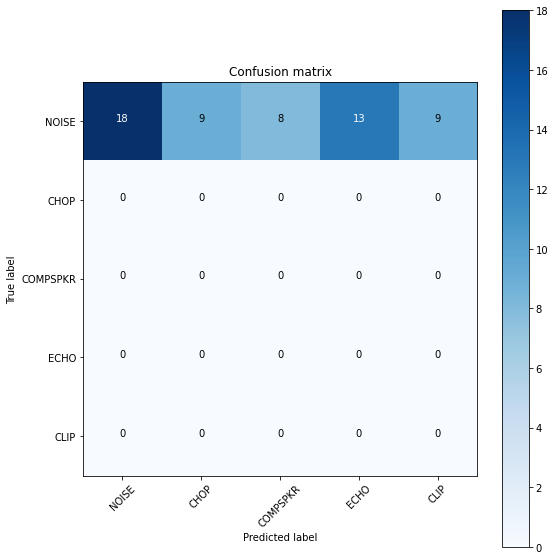

In [21]:
NOISE_CLASS_MAP = ['NOISE', 'CHOP', 'COMPSPKR', 'ECHO', 'CLIP']

# model.load_weights('drive/My Drive/audio-quality-cnn/multiclass.h5')
out_scores, out_probs = model.predict(test_dataset)
predictions = np.argmax(out_probs, axis=1)

print(predictions.shape)
conf_matrix = confusion_matrix(predictions, y_test_classes)
_ = plot_confusion_matrix(conf_matrix, classes=NOISE_CLASS_MAP)

In [44]:
X_train = np.load('../data/processed/TDC_VoIP_train_STFT_MAG.npy', allow_pickle=True).item()
X_test = np.load('../data/processed/TDC_VoIP_test_STFT_MAG.npy', allow_pickle=True).item()

In [45]:
train_filenames = X_train['filenames']
y_train_scores = X_train['sample_MOS']
y_train_classes = X_train['class_labels']
X_train_features = X_train['features']
input_height = X_train_features.shape[1]

print("Train data")
print("Features shape:", X_train_features.shape)
print("class_labels shape:", y_train_classes.shape)
print("sample_MOS shape:", y_train_scores.shape)

Train data
Features shape: (327, 257, 1241, 1)
class_labels shape: (327,)
sample_MOS shape: (327,)


In [46]:
test_filenames = X_test['filenames']
y_test_scores = X_test['sample_MOS']
y_test_classes = X_test['class_labels']
X_test_features = X_test['features']

print("Test data")
print("Features shape:", X_test_features.shape)
print("class_labels shape:", y_test_classes.shape)
print("sample_MOS shape:", y_test_scores.shape)

Test data
Features shape: (57, 257, 1241, 1)
class_labels shape: (57,)
sample_MOS shape: (57,)


In [47]:
def build_model1(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs

    # Conv --> BN --> Activation --> MaxPool --> [Dropout 2D]
    x = Conv2D(filters=16, kernel_size=3, padding='same', input_shape=input_shape)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=24, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=24, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.15)(x)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = SpatialDropout2D(0.25)(x)
    
    # scores branch 
    x_score = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x_score = BatchNormalization()(x_score)
    x_score = Activation('relu')(x_score)
    x_score = MaxPooling2D(pool_size=2)(x_score)
    x_score = SpatialDropout2D(0.25)(x_score)

    x_score = Conv2D(filters=32, kernel_size=3, padding='same')(x_score)
    x_score = BatchNormalization()(x_score)
    x_score = Activation('relu')(x_score)
    x_score = MaxPooling2D(pool_size=2)(x_score)
    x_score = SpatialDropout2D(0.25)(x_score)
    x_score = GlobalAveragePooling2D()(x_score)
    x_score = Dense(1, name='output_mos')(x_score)

#     # claas branch 
#     x_class = Conv2D(filters=32, kernel_size=3, padding='same')(x)
#     x_class = BatchNormalization()(x_class)
#     x_class = Activation('relu')(x_class)
#     x_class = MaxPooling2D(pool_size=2)(x_class)
#     x_class = SpatialDropout2D(0.25)(x_class)

#     x_class = Conv2D(filters=48, kernel_size=3, padding='same')(x_class)
#     x_class = BatchNormalization()(x_class)
#     x_class = Activation('relu')(x_class)
#     x_class = MaxPooling2D(pool_size=2)(x_class)
#     x_class = SpatialDropout2D(0.35)(x_class)
#     x_class = GlobalAveragePooling2D()(x_class)
#     x_class = Dense(NUM_CLASSES, activation='softmax', name='output_class')(x_class)
    
    model = Model(inputs=inputs, outputs=x_score)
    return model

In [50]:
model_MAG = build_model1((input_height, None, 1))

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model_MAG.compile(loss={'output_mos': 'mse'}, 
              loss_weights={'output_mos': 1},
              metrics={'output_mos': tf.keras.metrics.MeanAbsoluteError()},
              optimizer=optimizer)

# Display model architecture summary 
model_MAG.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 257, None, 1)]    0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 257, None, 16)     160       
_________________________________________________________________
batch_normalization_22 (Batc (None, 257, None, 16)     64        
_________________________________________________________________
activation_22 (Activation)   (None, 257, None, 16)     0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 128, None, 16)     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, None, 24)     3480      
_________________________________________________________________
batch_normalization_23 (Batc (None, 128, None, 24)     96  

In [51]:
history = model_MAG.fit(X_train_features,
          {'output_mos': y_train_scores},
          validation_data=(X_test_features, 
                           {'output_mos': y_test_scores}),
          batch_size=BATCH_SIZE,
          epochs=1000,
          callbacks=[early_stopping_callback]
        )

Train on 327 samples, validate on 57 samples
Epoch 1/1000
327/327 [==============================] - 110s 337ms/sample - loss: 17.5688 - mean_absolute_error: 4.0009 - val_loss: 12.5991 - val_mean_absolute_error: 3.4452
Epoch 2/1000
327/327 [==============================] - 111s 340ms/sample - loss: 14.9071 - mean_absolute_error: 3.6636 - val_loss: 13.7977 - val_mean_absolute_error: 3.6132
Epoch 3/1000
327/327 [==============================] - 112s 341ms/sample - loss: 13.1068 - mean_absolute_error: 3.4102 - val_loss: 14.0697 - val_mean_absolute_error: 3.6484
Epoch 4/1000
327/327 [==============================] - 111s 338ms/sample - loss: 11.9976 - mean_absolute_error: 3.2293 - val_loss: 13.5882 - val_mean_absolute_error: 3.5781
Epoch 5/1000
327/327 [==============================] - 112s 341ms/sample - loss: 10.7047 - mean_absolute_error: 3.0232 - val_loss: 12.6098 - val_mean_absolute_error: 3.4344
Epoch 6/1000
327/327 [==============================] - 112s 342ms/sample - loss: 9.9

327/327 [==============================] - 114s 347ms/sample - loss: 1.6863 - mean_absolute_error: 1.0348 - val_loss: 2.1992 - val_mean_absolute_error: 1.2917
Epoch 49/1000
327/327 [==============================] - 113s 344ms/sample - loss: 1.6565 - mean_absolute_error: 1.0611 - val_loss: 1.6017 - val_mean_absolute_error: 1.0822
Epoch 50/1000
327/327 [==============================] - 111s 339ms/sample - loss: 1.5684 - mean_absolute_error: 1.0202 - val_loss: 2.1272 - val_mean_absolute_error: 1.2669
Epoch 51/1000
327/327 [==============================] - 111s 339ms/sample - loss: 1.5663 - mean_absolute_error: 1.0126 - val_loss: 1.0680 - val_mean_absolute_error: 0.8755
Epoch 52/1000
327/327 [==============================] - 112s 341ms/sample - loss: 1.3837 - mean_absolute_error: 0.9340 - val_loss: 1.3539 - val_mean_absolute_error: 0.9997
Epoch 53/1000
327/327 [==============================] - 111s 340ms/sample - loss: 1.6388 - mean_absolute_error: 1.0231 - val_loss: 1.7514 - val_mean

327/327 [==============================] - 111s 339ms/sample - loss: 0.7675 - mean_absolute_error: 0.6898 - val_loss: 0.4464 - val_mean_absolute_error: 0.5504
Epoch 143/1000
327/327 [==============================] - 110s 338ms/sample - loss: 0.8923 - mean_absolute_error: 0.7549 - val_loss: 0.5858 - val_mean_absolute_error: 0.6281
Epoch 144/1000
327/327 [==============================] - 111s 340ms/sample - loss: 0.9452 - mean_absolute_error: 0.7774 - val_loss: 0.4400 - val_mean_absolute_error: 0.5468
Epoch 145/1000
327/327 [==============================] - 114s 347ms/sample - loss: 0.8853 - mean_absolute_error: 0.7464 - val_loss: 0.5076 - val_mean_absolute_error: 0.5871
Epoch 146/1000
327/327 [==============================] - 113s 345ms/sample - loss: 0.8261 - mean_absolute_error: 0.7212 - val_loss: 0.5581 - val_mean_absolute_error: 0.6111
Epoch 147/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.8124 - mean_absolute_error: 0.7349 - val_loss: 0.5433 - val

327/327 [==============================] - 113s 345ms/sample - loss: 0.7077 - mean_absolute_error: 0.6724 - val_loss: 0.3593 - val_mean_absolute_error: 0.4768
Epoch 237/1000
327/327 [==============================] - 114s 349ms/sample - loss: 0.5968 - mean_absolute_error: 0.6171 - val_loss: 0.3782 - val_mean_absolute_error: 0.4765
Epoch 238/1000
327/327 [==============================] - 115s 353ms/sample - loss: 0.6911 - mean_absolute_error: 0.6515 - val_loss: 0.3961 - val_mean_absolute_error: 0.4945
Epoch 239/1000
327/327 [==============================] - 114s 349ms/sample - loss: 0.7170 - mean_absolute_error: 0.6888 - val_loss: 0.6453 - val_mean_absolute_error: 0.6431
Epoch 240/1000
327/327 [==============================] - 114s 348ms/sample - loss: 0.6635 - mean_absolute_error: 0.6515 - val_loss: 0.4358 - val_mean_absolute_error: 0.5292
Epoch 241/1000
327/327 [==============================] - 114s 350ms/sample - loss: 0.6672 - mean_absolute_error: 0.6296 - val_loss: 0.4722 - val

327/327 [==============================] - 111s 339ms/sample - loss: 0.5278 - mean_absolute_error: 0.5747 - val_loss: 0.5928 - val_mean_absolute_error: 0.6151
Epoch 331/1000
327/327 [==============================] - 111s 341ms/sample - loss: 0.5589 - mean_absolute_error: 0.5979 - val_loss: 0.4361 - val_mean_absolute_error: 0.5214
Epoch 332/1000
327/327 [==============================] - 111s 338ms/sample - loss: 0.5386 - mean_absolute_error: 0.5803 - val_loss: 0.3887 - val_mean_absolute_error: 0.4953
Epoch 333/1000
327/327 [==============================] - 111s 338ms/sample - loss: 0.5680 - mean_absolute_error: 0.6007 - val_loss: 0.7914 - val_mean_absolute_error: 0.7199
Epoch 334/1000
327/327 [==============================] - 113s 347ms/sample - loss: 0.6010 - mean_absolute_error: 0.6208 - val_loss: 0.3716 - val_mean_absolute_error: 0.4830
Epoch 335/1000
327/327 [==============================] - 111s 340ms/sample - loss: 0.5925 - mean_absolute_error: 0.6178 - val_loss: 0.4312 - val

327/327 [==============================] - 111s 340ms/sample - loss: 0.4649 - mean_absolute_error: 0.5532 - val_loss: 0.3728 - val_mean_absolute_error: 0.4610
Epoch 425/1000
327/327 [==============================] - 113s 346ms/sample - loss: 0.4501 - mean_absolute_error: 0.5386 - val_loss: 0.3409 - val_mean_absolute_error: 0.4538
Epoch 426/1000
327/327 [==============================] - 111s 341ms/sample - loss: 0.4693 - mean_absolute_error: 0.5289 - val_loss: 0.3530 - val_mean_absolute_error: 0.4545
Epoch 427/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.4895 - mean_absolute_error: 0.5581 - val_loss: 0.4386 - val_mean_absolute_error: 0.5220
Epoch 428/1000
327/327 [==============================] - 111s 340ms/sample - loss: 0.4792 - mean_absolute_error: 0.5456 - val_loss: 0.3338 - val_mean_absolute_error: 0.4532
Epoch 429/1000
327/327 [==============================] - 111s 340ms/sample - loss: 0.4707 - mean_absolute_error: 0.5516 - val_loss: 0.3471 - val

327/327 [==============================] - 111s 340ms/sample - loss: 0.3437 - mean_absolute_error: 0.4658 - val_loss: 0.3301 - val_mean_absolute_error: 0.4364
Epoch 519/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.4438 - mean_absolute_error: 0.5419 - val_loss: 0.4560 - val_mean_absolute_error: 0.5093
Epoch 520/1000
327/327 [==============================] - 112s 342ms/sample - loss: 0.3773 - mean_absolute_error: 0.4881 - val_loss: 0.3354 - val_mean_absolute_error: 0.4439
Epoch 521/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.4139 - mean_absolute_error: 0.5047 - val_loss: 0.5229 - val_mean_absolute_error: 0.5519
Epoch 522/1000
327/327 [==============================] - 111s 341ms/sample - loss: 0.4367 - mean_absolute_error: 0.5318 - val_loss: 0.3328 - val_mean_absolute_error: 0.4403
Epoch 523/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.3899 - mean_absolute_error: 0.5029 - val_loss: 0.4237 - val

327/327 [==============================] - 111s 341ms/sample - loss: 0.3332 - mean_absolute_error: 0.4658 - val_loss: 0.4012 - val_mean_absolute_error: 0.4831
Epoch 613/1000
327/327 [==============================] - 111s 340ms/sample - loss: 0.3475 - mean_absolute_error: 0.4648 - val_loss: 0.3456 - val_mean_absolute_error: 0.4511
Epoch 614/1000
327/327 [==============================] - 111s 341ms/sample - loss: 0.3719 - mean_absolute_error: 0.4911 - val_loss: 0.4086 - val_mean_absolute_error: 0.4900
Epoch 615/1000
327/327 [==============================] - 111s 339ms/sample - loss: 0.4297 - mean_absolute_error: 0.5192 - val_loss: 0.3581 - val_mean_absolute_error: 0.4576
Epoch 616/1000
327/327 [==============================] - 112s 342ms/sample - loss: 0.3697 - mean_absolute_error: 0.4758 - val_loss: 0.3945 - val_mean_absolute_error: 0.4735
Epoch 617/1000
327/327 [==============================] - 112s 343ms/sample - loss: 0.3377 - mean_absolute_error: 0.4576 - val_loss: 0.3915 - val

In [67]:
result = pd.DataFrame({'true score' :y_test_scores.tolist(),'predicted score': model_MAG.predict(X_test_features).tolist()})

In [68]:
result.head()

,true score,predicted score
0,3.583333,[3.709881067276001]
1,4.750000,[3.1057536602020264]
2,2.666667,[2.9251439571380615]
3,3.916667,[3.3373584747314453]
4,4.000000,[3.8825602531433105]


In [61]:
result.head()

,true score,predicted score
0,3.583333,3.709881


In [56]:
model_MAG.save('../models/model_mga.h5')